In [1]:
import pandas as pd
import numpy as np
import os
from os.path import isdir, isfile
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# for scoring predictions
import ml_metrics as metrics

# for saving models
from joblib import dump, load

In [2]:
# variable descs are here: http://kaushal-desai.us/expedia-recommender-system/
# this loads the dataset from the current working directory. It can be downloaded here:
#     https://www.kaggle.com/c/expedia-hotel-recommendations/data?select=train.csv

df_full = pd.read_csv('hotel_train.csv')

In [3]:
''' Separate off test data. I'm taking an unusually small fraction for testing because
    my predictions take a long time. It's still over 100,000 records for testing.
'''
df_tr, df_te = train_test_split(df_full, test_size=0.01, random_state = 1)

# delete df_full to free up memory
del df_full

In [4]:
# For training purposes, I'll drop the rows with nan and non-numeric columns
df_tr = df_tr.select_dtypes(include=np.number).dropna()

In [5]:
# Check the length of the training and testing sets
print(len(df_tr))
print(len(df_te))

7575230
119624


That's a lot of records. I'm going to start with a subset, hone my technique there, then go back to the larger set.

I actually don't want to balance my classes here. There are rarely booked clusters, and if I balance classes in my training set, the effect this has on the model is a willingness to sacrifice some accuracy in predicting the most popular hotel clusters in exchange for a comparable increase in accuracy in prediction for the rarely booked clusters. From a business perspective (and by the metrics given in the challenge), this tradeoff does not make sense. The aim is to get as many predictions correct as possible. So the oft-booked clusters should be privileged with overrepresentation in the training set, proportionate to their overrepresentation in the booking data.

In [6]:
# sample 100,000 records
df = df_tr.sample(n=100000)

# split into train and test dataframes. df is already randomized.
tr = df.iloc[:70000,:]
te = df.iloc[70000:,:]

# reset indices
tr = tr.reset_index(drop=True)
te = te.reset_index(drop=True)

# check shape
print(tr.shape)
print(te.shape)

(70000, 21)
(30000, 21)


In [7]:
# Get the most prevalent five clusters, in descending order
top_clusters = [_ for _ in df_tr.hotel_cluster.value_counts().head().index]

# Guess the top five clusters regardless of record info
predictions = [top_clusters for i in range(len(te))]

# Check guesses
target = [[_] for _ in te["hotel_cluster"]]
metrics.mapk(target, predictions, k=5)

0.06165722222222222

This doesn't work well.

The variable srch_destination_id identifies the region targeted by the search. It stands to reason that we should modify our guesses based on the clusters prevalent per location. What if I guess the top five clusters based on the search destination id?

In [8]:
def top_five(dest):
    ''' accepts: the search target location (srch_destination_id)
        returns: the top five (by prevalence in records) hotel clusters at the location
        notes:   if there are fewer than five hotel_clusters, we fill out the list by
                 repeatedly appending the first hotel cluster in the list so far.
    '''
    ls = [cl for cl in tr[tr.srch_destination_id==dest].hotel_cluster.value_counts().head().keys()]
    # In case there are no hotel_clusters associated with the location, just guess the top 5 overall.
    if len(ls)==0:
        return([91,41,48,64,65])
    # The score calculator expects five guesses, so fill out a shorter list.
    while len(ls)<5:
        ls.insert(0,ls[0])
    return(ls)

In [9]:
# Make predictions
te.pred = te['srch_destination_id'].apply(top_five)

# Check guesses
target = [[_] for _ in te["hotel_cluster"]]
metrics.mapk(target, te.pred, k=5)

/home/chris/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0.24062166666666665

This is a big improvement, and we've used no machine learning yet! Let's see what we can do by incorporating some machine learning models.

Before trying to get creative, I'm going to throw some models at the data: logistic regression, LDA, KNN, naive Bayes, a decision tree classifier, a neural network, and a SVM. The idea here is not to get a good prediction, but to figure out which type of model might be best employed in a more careful attempt. I'll try these models on a small subset of the data.

In [10]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NN', MLPClassifier(hidden_layer_sizes=(30,30), max_iter=75)))
models.append(('SVM', SVC(gamma='auto')))

In [11]:
# Sample 20,000 records
df = df_tr.sample(n=20000, random_state=1)

# Split into test and train sets, and break off the target variable
array = df.values
X = array[:,:20]
y = array[:,20]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('{}: {} ({})'.format(name, cv_results.mean(), cv_results.std()))

LR: 0.052714285714285714 (0.004503966505838413)
LDA: 0.06335714285714286 (0.00395187891246373)
KNN: 0.014714285714285713 (0.003116774889895918)
CART: 0.0725 (0.007229827671754375)
NB: 0.05935714285714285 (0.004817591065404928)


/home/chris/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/chris/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/chris/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/chris/.local/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.ma

NN: 0.03385714285714286 (0.00034992710611188337)
SVM: 0.03628571428571429 (0.0010973065354098008)


It looks like the decision tree is superior (factoring in both accuracy and time to train). I'll proceed with that.

Here's the plan: I had good success predicting hotel_cluster by just choosing the top five hotel_cluster for the record's srch_destination_id. I will improve on this by using machine learning for each srch_destination_id instead of just naively selecting the top five clusters for each srch_destination_id.

There are 100 hotel clusters (not all of which are represented in each srch_destination_id). To make predictions for a particular srch_destination_id, I will iterate over all hotel_cluster represented in that srch_destination_id, and create a separate decision tree model for each of these hotel clusters. The output of each decision tree will be 1 or 0 depending on whether it judges its particular hotel_cluster is represented in that record. To make a prediction for a particular record, I'll run each of the trees, and select all of the positive predictions. If there are fewer than five positive predictions, I'll fill out the rest of my five guesses from the top hotel_clusters for that srch_destination_id. If there are more than five positive predictions, I'll order them by popularity for the srch_destination_id, and take the top five in the list.

There are about 33,000 unique values of srch_destination_id, and I'll be training up to 100 decision trees per srch_destination_id. This means training a lot of decision trees. I don't think I can create trees for all the records. To optimize the impact of the resources I do have, I'll order the srch_destination_id by the number of records associated with them. For example, the srch_destination_id with the most records is 8250, with about 333,000 records. That means my first 100 decision trees will cover a lot of records. Let's have a look.

Text(0, 0.5, 'Percentage of records covered')

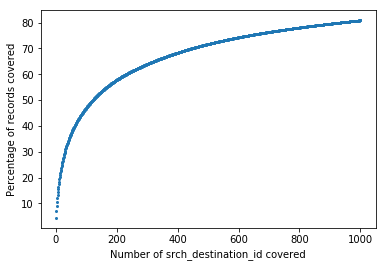

In [13]:
# Graph the percentage of all records covered vs number of srch_destination_id covered

num_records = len(df_tr)

xs = [i for i in range(1,1001)]
ys = []
for num in df_tr.srch_destination_id.value_counts().values[:1000]:
    if len(ys)==0:
        ys.append(num)
    else:
        ys.append(ys[-1]+num)
ys=[100*y/num_records for y in ys]

plt.scatter(xs, ys, s=4)
plt.xlabel('Number of srch_destination_id covered')
plt.ylabel('Percentage of records covered')

Text(0, 0.5, 'Percentage of records covered')

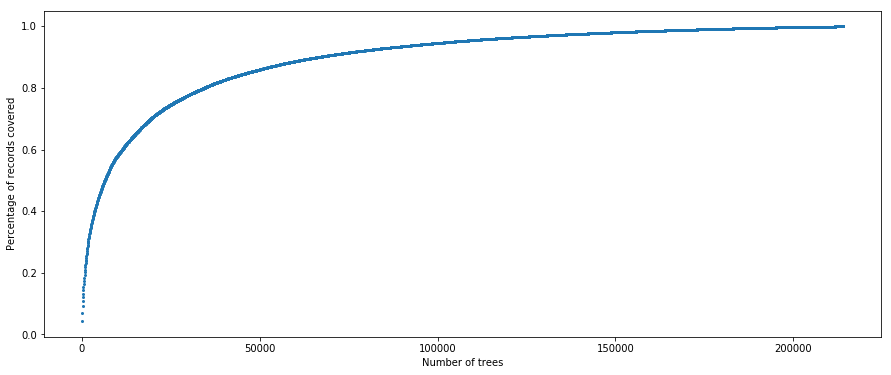

In [14]:
# Graph the percentage of all records covered vs number of decision tree models trained

xs = []
ys = []
z = df_tr.srch_destination_id.value_counts()
for i in z.index:
    num_trees = len(df_tr[df_tr.srch_destination_id==i].hotel_cluster.unique())
    if len(xs)==0:
        xs.append(num_trees)
    else:
        xs.append(xs[-1]+num_trees)
    if len(ys)==0:
        ys.append(z[i])
    else:
        ys.append(ys[-1]+z[i])
ys=[y/num_records for y in ys]

plt.figure(figsize=(15, 6))
plt.scatter(xs, ys, s=4)
plt.xlabel('Number of trees')
plt.ylabel('Percentage of records covered')

Proceeding in this way, rather than training a theoretical maximum 3.3 million models, I can cover most of the records with just 20,000 or so models. As for the records not covered by decision trees, I will revert to guessing the top five clusters for that srch_destination_id. This strategy may work better than it appears at first glance, as I am using the naive top-five strategy for records unlikely to have many hotel clusters; in particular, I'm sure to guess (although not in the right order) the correct cluster for any record with a srch_destination_id with at most five associated hotel_clusters. 

I think there would be benefits to an ensemble approach. Given more memory, I'd create an ensemble with LDA, decision trees, and Naive Bayes. However, given more memory, I'd also create more decision trees covering more of the records. I think the marginal memory is better spent covering more records with one model, rather than covering fewer records with several models. This hypothesis could be checked on a small data set.

Let's begin to organize the models. I will create a meta dictionary "ddict" whose keys are srch_destination_id and whose values are in turn dictionaries. These subdictionaries will have the unique hotel_cluster associated to the srch_destination_id as keys and decision tree models corresponding to those clusters as values.

In [15]:
# This is the dictionary to store the dictionaries of models
ddict = {}

In [16]:
# A utility function to create augmented dataframes to train the individual trees (per hotel_cluster)
# It will be used to add an indicator variable for the hotel_cluster.

def cluster_indicator(cluster,i):
    ''' accepts: a hotel_cluster and an integer
        returns: 1 if they are equal, 0 otherwise
    '''
    if cluster==i: return(1)
    return(0)

In [17]:
''' Train the trees. It took about 25 minutes to train about 4000 trees on my machine.
    They start slow (since the largest ones are first).
# '''

progress = 0 # a counter used as a mechanism to break the process by user input

# store the srch_destination_ids in descending order of prevalence in the full dataframe
srch_dest_ids = df_tr.srch_destination_id.value_counts().index

for n in srch_dest_ids:
    if n in ddict.keys(): pass # check if we've already handled that srch_destination_id
    else:
        progress +=1
        print('working on {}'.format(n))
        if progress%3000==0:
            # pause to give user the option to break. I used it to save off models, as I expected running
            # the whole process at once would exhaust my memory
            cont = input('Continue? y/n')
            if cont.lower()=='n': break
        
        # get the subset of df_tr consisting of records with the particular srch_dest_id
        dfr = df_tr[df_tr.srch_destination_id==n]

        # initialize the subdictionary which will hold this srch_dest_id's models
        ddict[n]={}
        
        # separate off the training data
        X=dfr.values[:,:20]

        # for each hotel_cluster, train a model and store it in the subdict 
        for i in dfr.hotel_cluster.unique():
            y = dfr['hotel_cluster'].apply(cluster_indicator, args = [i])
            X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.3, random_state=1)

            ddict[n][i]=DecisionTreeClassifier()
            ddict[n][i].fit(X_train, Y_train)

In [18]:
# Save models

for i in ddict.keys():
    if not os.path.isdir('saved_models/{}'.format(int(i))):
        os.makedirs('saved_models/{}'.format(int(i)))
    for j in ddict[i].keys():
        if not os.path.isfile('saved_models/{}/{}.joblib'.format(int(i),int(j))):
            dump(ddict[i][j], 'saved_models/{}/{}.joblib'.format(int(i),int(j)))

In [22]:
# Load models from disk

ddict = {}
for direc in os.listdir('saved_models/'):
    srch_dest_id = int(direc)
    ddict[srch_dest_id]={}
    for filename in os.listdir('saved_models/{}/'.format(direc)):
        cluster=int(filename.split('.')[0])
        ddict[srch_dest_id][cluster]=load('saved_models/{}/{}'.format(direc,filename))

Let's see what percentage of the records are covered by the models trained so far.

In [23]:
# check to see how many records are covered by the models trained so far
tot = 0
for id in ddict.keys():
    tot += len(df_tr[df_tr['srch_destination_id']==id])
print('{}% of records are covered by models.'.format(round(100*tot/num_records,1)))

93.3% of records are covered by models.


I suppose that's good enough. Let's test.

In [24]:
# A function to generate predictions based on the trained models

def ddict_pred(x):
    ''' accepts: a record (with non-numerics strippedp) from the test set
        returns: a list of five predicted hotel_clusters.
        notes:   if the record does not have an associated decision tree,
                 this will just return the overall top five hotel_clusters.
                 I intended to return the top five for the record's
                 srch_destination_id, but something was not working with it.
    '''
    x=x.values.reshape(1,-1)
    if x[0][13] in ddict.keys():
        preds = []
        val_cts = df_tr[df_tr['srch_destination_id']==x[0][13]].hotel_cluster.value_counts()
        for j in ddict[x[0][13]].keys():
            try: preds.append((j,ddict[x[0][13]][j].predict(x)))
            except: return(top_clusters)
                #except: print('not fitted: {} in {}'.format(j,x[0][13]))

        # the positive predictions
        pred_pos = [_[0] for _ in preds if _[1]==1]

        if len(pred_pos)<5:
            # supplement the prediction list with the prevalent clusters in the search destination
            N = len(val_cts)-1
            count = 0
            while len(pred_pos)<5: # goes down the list of common clusters not yet in pred_pos
                # cycles back to the beginning if this list is less than 5-len(pred_pos) in length
                remainder = [_ for _ in val_cts.index if _ not in pred_pos]
                try: pred_pos.append(remainder[count%N]) # breaks if there is no remainder
                except: # so we have all the options in pred_pos already. just append the first until length==5
                    while len(pred_pos)<5:
                        pred_pos.append(pred_pos[0])
                    break
                count+=1
            pred_final = pred_pos
        else:
            # orders the predicted cluster according to their prevalence in the search destination
            pred_final = [value for value in val_cts.index if value in pred_pos]
            # cut to five predictions
            pred_final = pred_final[:5]
        return(pred_final)
    else:
        return(top_clusters) # TODO why is this broken, need top five.
        #return(top_five(x[0][13]))

In [25]:
# Split off the test target
target = [[_] for _ in df_te.select_dtypes(include=np.number)["hotel_cluster"]]

# Drop the non-numeric columns, which I don't use for the prediction
df_te = df_te.iloc[:,:-1].select_dtypes(include=np.number)

In [803]:
''' Generate the test predictions.
    This took two hours on my machine.
'''

te.pred = df_te.apply(ddict_pred,axis=1)

In [810]:
score = metrics.mapk(target, te.pred, k=5)
print('Model score: {}'.format(round(score,3)))

Model score: 0.512


## Conclusion

This is good accuracy. Unfortunately, the predicting is slow. It takes two hours to generate 100,000 predictions, so for the full test file it should take around 80 hours on my machine. It could be done, as memory was not close to running out, and would not run out for the full test file of ~4million records.

Improvements which should be straightforward:
* Feature selection.
* Finish training models for all srch_destination_id values.
* Take an ensemble approach with decision trees, LDA, and naive Bayes.
* Implement calibrated classifiers to give probabilistic contexts to the classifier outputs.

Unresolved issues:
* I could not get the top_five function working within my model prediction function. Instead, I just assigned the top five overall hotel_cluster list to any srch_destination_id which did not have a model trained for it. By getting the top_five per srch_destination_id working within my model prediction, I estimate I would increase the score by 0.05 to 0.1 on my reduced test set.

## Spare code

In [ ]:
# # code for selecting balanced classes (I argued above why we shouldn't)

# # how many records for each hotel cluster?
# df_tr[df_tr.is_booking == 1].hotel_cluster.value_counts()

# # verifying the unique hotel cluster values
# df.hotel_cluster.unique()

# # balance the sample on hotel_cluster. I think I can do this manually:
# df_sample = blank dataframe
# for each of the values in df.hotel_cluster.values():
#    temp_dataframe = randomly sample 5000 lines from df[df.hotel_cluster==value]
#    append temp_dataframe to df_sample
# shuffle df_sample
# reindex df_sample

# ''' The most rarely booked cluster has 766 records. We can get a good-sized, balanced subset
#     taking 750 records corresponding to each hotel cluster.
# '''

# # initialize the sampled dataframe
# df = pd.DataFrame(columns=df.columns)

# for i in df_tr.hotel_cluster.unique():
#     if i==i: # I was getting nan as a value in the loop for some reason
#         df_temp = df_tr[(df_tr.is_booking == 1)&(df_tr.hotel_cluster==i)].sample(n=750)
#         df = df.append(df_temp)
        
# # the sample should only be drawn from is_booking == 1 (as the test set is like that)

# # check that it worked
# print(df.shape)
# df.hotel_cluster.value_counts()

In [ ]:
# # calibrated classifier - for improvements over just taking top 5 positive results
# # this is how we would get the model to output probabilities instead of just 0 or 1.

# from sklearn.calibration import CalibratedClassifierCV
# base_clf = DecisionTreeClassifier()
# calibrated_clf = CalibratedClassifierCV(base_estimator=base_clf, cv=2)
# calibrated_clf.fit(X_train, Y_train)

In [ ]:
# # For PCA
# from sklearn import decomposition

# pca = decomposition.PCA(n_components=5)
# pca.fit(X)
# X=pca.transform(X)